In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-12-19 01:41:38--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-12-19 01:41:38 (5.70 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



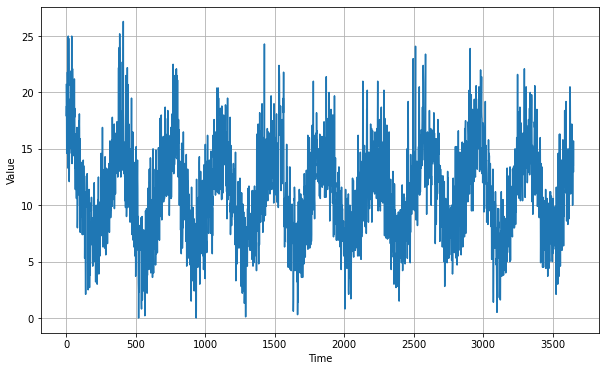

In [17]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  next(csvfile)
  time = 1
  for line in csvfile:
    ln = line.strip().split(",")
    time_step.append(time)
    time += 1
    temps.append(float(ln[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [18]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [34]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    # No shuffle
    # No map
    dataset = dataset.batch(32).prefetch(1)
    forcast = model.predict(dataset)
    return forcast


In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 14s 59ms/step - loss: 31.1418 - mae: 31.6401 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 55ms/step - loss: 30.5657 - mae: 31.0639 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 56ms/step - loss: 29.6745 - mae: 30.1726 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 28.5571 - mae: 29.0549 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 56ms/step - loss: 27.1948 - mae: 27.6923 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 55ms/step - loss: 25.4979 - mae: 25.9952 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 54ms/step - loss: 23.3389 - mae: 23.8356 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 55ms/step - loss: 20.5994 - mae: 21.0955 - lr: 2.

(1e-08, 0.0001, 0.0, 60.0)

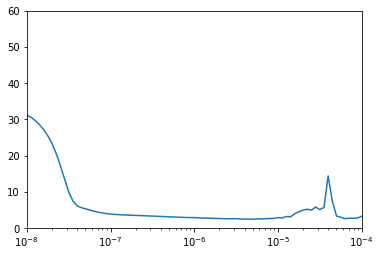

In [28]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate= 5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 6s 39ms/step - loss: 9.8543 - mae: 10.3424
Epoch 2/100
25/25 [==============================] - 1s 37ms/step - loss: 3.2358 - mae: 3.7062
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 2.6824 - mae: 3.1479
Epoch 4/100
25/25 [==============================] - 1s 37ms/step - loss: 2.4411 - mae: 2.9028
Epoch 5/100
25/25 [==============================] - 1s 37ms/step - loss: 2.4461 - mae: 2.9074
Epoch 6/100
25/25 [==============================] - 1s 37ms/step - loss: 2.5470 - mae: 3.0108
Epoch 7/100
25/25 [==============================] - 1s 37ms/step - loss: 2.4133 - mae: 2.8747
Epoch 8/100
25/25 [==============================] - 1s 37ms/step - loss: 2.3116 - mae: 2.7718
Epoch 9/100
25/25 [==============================] - 1s 37ms/step - loss: 2.4293 - mae: 2.8908
Epoch 10/100
25/25 [==============================] - 1s 37ms/step - loss: 2.3607 - mae: 2.8219
Epoch 11/100
25/25 [============================

In [35]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

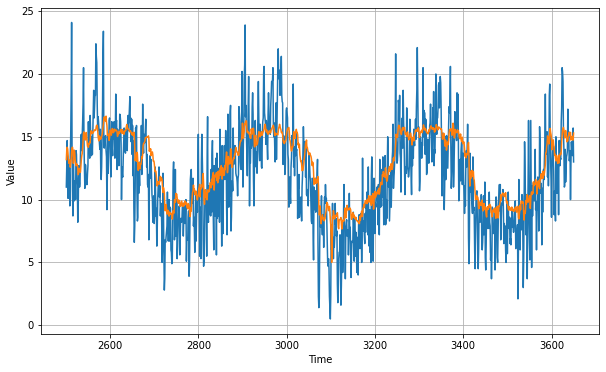

In [36]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [37]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.1984835

In [38]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[13.186357 13.912909 14.169752 ... 14.742973 14.745819 15.295288]
